### MMDetection

In [1]:
import torch
print(torch.__version__)
# mmdetection 패키지가 torch 기반으로 구축되어있음.
# mmdetection 설치시, torch와 버전이 맞아야 동작함.

1.12.1+cu113


→ torch와 cuda version에 맞게 패키지 설치

In [2]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
     |████████████████████████████████| 40.6 MB 15.7 MB/s 
     |████████████████████████████████| 190 kB 12.6 MB/s 


In [3]:
!git clone https://github.com/open-mmlab/mmdetection.git
# git clone
!cd mmdetection; python setup.py install
# 필요한 패키지 전부 맞추기

Cloning into 'mmdetection'...
remote: Enumerating objects: 31148, done.
remote: Counting objects: 100% (1678/1678), done.
remote: Compressing objects: 100% (881/881), done.
remote: Total 31148 (delta 882), reused 1339 (delta 769), pack-reused 29470
Receiving objects: 100% (31148/31148), 40.92 MiB | 20.28 MiB/s, done.
Resolving deltas: 100% (21987/21987), done.
running install
running bdist_egg
running egg_info
creating mmdet.egg-info
writing mmdet.egg-info/PKG-INFO
writing dependency_links to mmdet.egg-info/dependency_links.txt
writing requirements to mmdet.egg-info/requires.txt
writing top-level names to mmdet.egg-info/top_level.txt
writing manifest file 'mmdet.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'mmdet.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mmdet
copying mmdet/version.py -> build/

*주의 : import 하기 전에 런타임을 다시 시작해야함.*
 <br>방법 : 위 상단의 런타임 클릭 → 런타임 다시시작 클릭

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from IPython.display import Image

1. R-CNN
  - Image를 입력
  - Selective search 알고리즘으로 RoI(region proposal output) 약 2000개 추출
      - SS : 색상, 질감, 영역 등으로 segmentation 수행 후, Bottom-up 방식으로 작은 영역을 합쳐서 큰 영역을 만든다. 반복하여 최종적으로 2000개 추출
  - 위에서 추출한 output을 모두 동일한 형태(224x224)로 조정(CNN의 input으로 넣기 위해서)
  - CNN으로 각 이미지에 대해 feature vector 출력
  - 1) 뽑아낸 feature vector를 갖고 SVM을 통해 classification 작업을 진행
  - 2) 뽑아낸 feature vector를 갖고 linear bounding-box regression을 진행

→ 2000번의 CNN 연산 매우 느리다.

2. Fast R-CNN<br>
기존의 RCNN은 RoI를 각각 CNN을 적용했어야한다.
  - 전체 이미지를 CNN에 통과시킨다.
  - Selective search로 찾은 2000개의 영억을 CNN을 통과한 영역에 projection 시킨다.
  - RoI Pooling을 진행시켜 고정된 크기의 feature vector를 얻는다.
    - RoI Pooling : input의 사이즈를 동일하게 조절하기 위해 원하는 사이즈로 Max Pooling
  - 1) 하나는 softmax를 통과하여 classification
  - 2) 하나는 bounding box regression을 통해 box regression

→ 그래도 계속 Selective Search를 사용해야한다.

3. Faster R-CNN<br>
SS를 모델안으로 넣는 RPN 추가
  - RPN : 다양한 객체를 감지할 수 있는 anchor box(9개의 서로 다른 box)를 sliding 하여 classification과 regression을 진행
  - IoU를 기준으로 0.7보다 크면 positive 0.3은 background 나머지는 사용하지 않는다.
  - 한 객체당 여러개의 proposal이 나올 수 있는데, NMS알고리즘으로 줄인다.(800개)
  - 이후 bounding box regression, classificaiton

## Detection model Architecture

* Detection을 위해서 아래와 같이 Backbone(ResNet)과 Neck(Feature Pyramid Network)를 통과하여 Head에서 bounding box regression과 classification이 이루어진다.

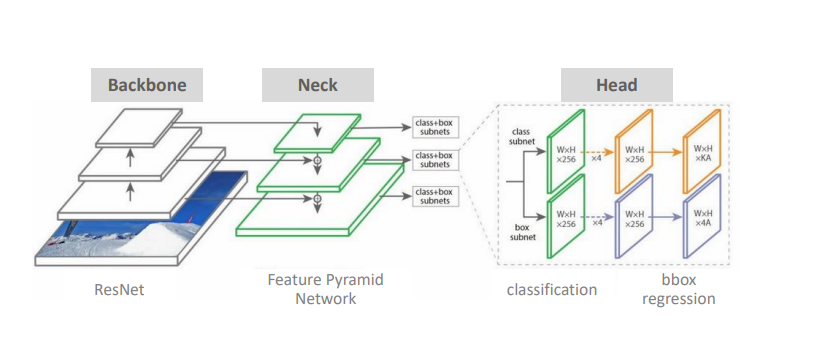

In [3]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/04/frat.png')

* Backbone : input image를 feature map으로 변경하는 부분
* Neck : Backbone과 Head를 연결하는 부분 : feature map을 정제하고 재구성하는 부분
* Head : 추출한 feature map을 Prediction하는 부분

* Feature Pyramid Network는 bottom-up 방식과 top-down 방식의 결합으로 아래의 그림과 같이 구성된다.
    - low level, mid level, high level feature를 얻을 수 있다.

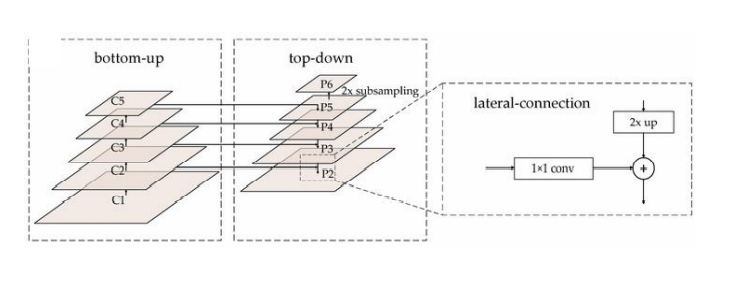

In [4]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/04/fpn.png')

→ 다양한 층에서의 low, mid, high feature를 추출하여 더 다양한 크기의 객체를 탐지할 수 있게 한다.

* Detection Model은 two-stage model과 single-stage model이 있다. 
    - RCNN은 two-stage model이다.

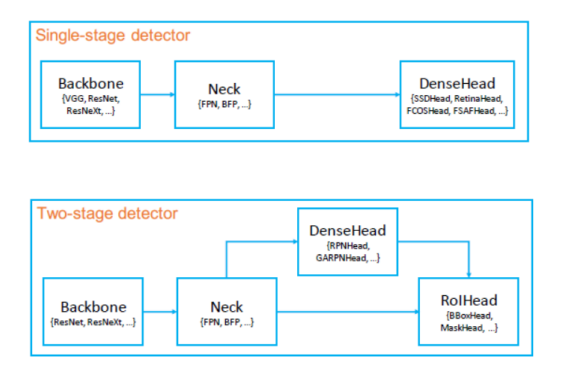

In [5]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/04/mmd.png')

▷ 위와 같이 RCNN이 구성된다. 그런데, 이러한 과정을 복잡한 코드작성이 아닌 구현되어있는 패키지를 통해서 (나름)간단하게 수행할 수 있다. 

## MMDetection
* 여러가지 모델들을 사전에 구현해둔 일종의 플랫폼이다.
* 사용할 모델, 가중치, 데이터를 불러오고, Config file이라는 데이터 학습방법, 모델, 가중치 사용 등의 내용이 담겨져 있는 파일을 수정함에따라서 학습을 쉽게 진행할 수 있다.

#### *주의 : 따라서 MMDetection을 사용하려면 MMDetection이 읽어올 수 있도록 데이터를 정렬시켜주어야한다.

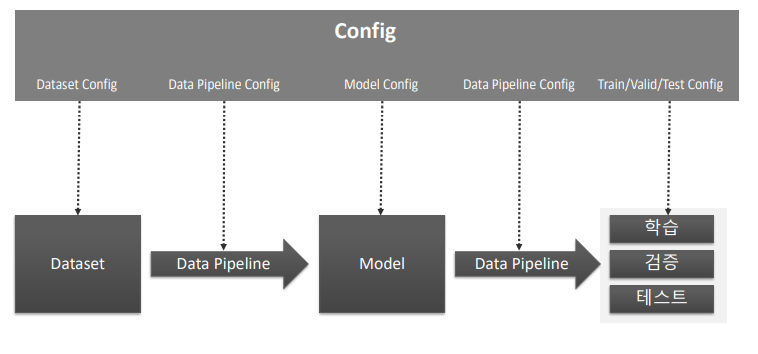

In [6]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/04/cfg.png')

[구성]
* config : dataset, pipeline, model, optimizer, loss, epoch 등에 대한 내용 
* hook(callback)도 config에서 설정
<br> ▷ 손으로 Model을 직접 구현하지 않고 MMDetection을 잘 사용하는 방법에 대해서 실습할 것. 

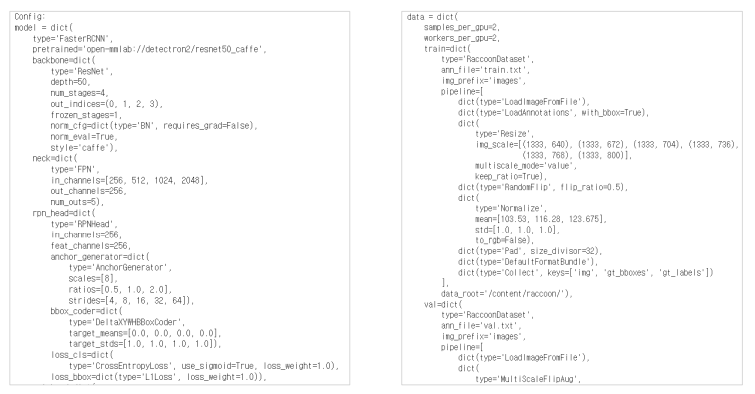

In [7]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/04/config.png')

 1) Model 
  - model : 어떤 모델을 사용할 것인지 → FasterRCNN
  - pretrained : 사용한 가중치 → resnet50
  - backbone : backbone model → resnet50
  - neck : 연결 형태 → FPN 
  - rpn_head : RPN
  - loss : crssentropy<br>
  → 실험을 통해서 가장 잘 학습할 수 있는 조합을 미리 구성한 것


2) Data
 - train 데이터 경로
 - 좌표 경로
 - 이미지 전처리 내용

In [8]:
import mmcv
# 위에서 다운로드한 mmcv

In [9]:
from mmdet.apis import init_detector, inference_detector
# detection 하기 위한 function

### MS-COCO 데이터 기반으로 Faster RCNN Pretrained 모델을 활용하여 Inference 수행
* Faster RCNN Pretrained 모델 다운로드
* Faster RCNN용 Config 파일 설정.  
* Inference 용 모델을 생성하고, Inference 적용

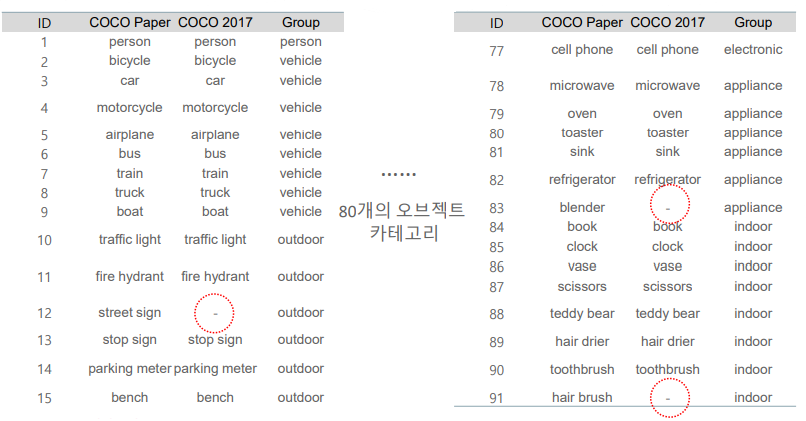

In [10]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/04/coco.png')

▷ 91개의 index가 존재하지만, 중간 중간 비어있는 데이터가 있어서 이러한 데이터를 제외하면, 총 80개의 Object가 남는다. 
* 주요 오픈소스 패키지는 COCO Dataset으로 학습된 모델을 제공한다.


In [11]:
!cd mmdetection; mkdir checkpoints
# coco dataset으로 pretrained된 모델을 다운로드 받기 위해서 mmdetection/checkpoints 디렉토리를 만듬. 

* 사전에 학습되어있는 가중치 다운로드

In [12]:
!wget -O /content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
# wget 이러한 파일을 이 이름으로 이 링크에서 다운 받겠다.
# coco기반으로 faster rcnn 사전 학습된 모델 다운 받기(resnet50 + fpn12 epoch)
# mmdetection github에 가면 config파일과 저장된 모델 파일이 존재

--2022-08-31 06:50:13--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.187.167
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.187.167|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

/content/mmdetectio 100%[===================>] 159.54M  12.3MB/s    in 13s     

2022-08-31 06:50:26 (12.3 MB/s) - ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [13]:
# /content/mmdetection/checkpoints
# 경로로 들어가서 파일 확인
# pth로 저장되어있는 가중치 파일을 확인할 수 있다.

* Model에 대한 구성, 가중치 등을 설정하는 파일

In [14]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
# config 파일 : 이렇게 모델/데이터/방법론이 적용되면 좋겠다라는 정보가 들어가 있음.
checkpoint_file = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
# 가중치 파일 : 사전에 학습되어있는 가중치.

* Model 설정 : 사전에 정의되어있는 init_detector에 config_file, checkpoint_file을 입력하여 Model 구성

In [15]:
# config 파일과 pretrained 모델을 기반으로 Detector 모델을 생성. 
model = init_detector(config_file, checkpoint_file, device='cuda:0')
# config_file : 해당하는 config , chckpoint_file : 학습된 모델, device : gpu 설정 1개 차례대로 입력.

load checkpoint from local path: /content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


* 실험에 사용할 이미지

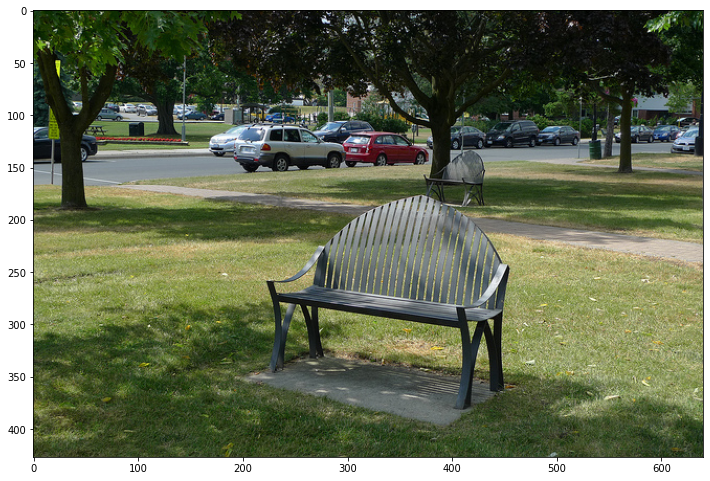

In [16]:
import cv2
import matplotlib.pyplot as plt
img = '/content/mmdetection/demo/demo.jpg'
# 우리가 detection할 image

img_arr  = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(img_arr)

* detection

In [17]:
img = '/content/mmdetection/demo/demo.jpg'
results = inference_detector(model, img) 
# detect하는 함수
# model과 이미지의 경로 입력

/usr/local/lib/python3.7/dist-packages/mmdet-2.25.1-py3.7.egg/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


In [18]:
type(results), len(results)
# len이 80개이다 : coco dataset class갯수
# 80개의 객체에 대해서 각 몇개씩 찾았고 좌표가 어디인지 나온다.

(list, 80)

## 결과 확인
* results : 아래와 같이 각각의 class_id 별로 위치하고 있는 좌상단, 우하단의 좌표와 class_confidence score로 구성되어있다.
    - 존재하지 않으면 class_id 1과 같이 비어있고, 여러개가 존재하면 class_id 2와 같이 여러 열의 list로 구성되어있다.

In [ ]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/04/config2.png')

In [ ]:
results
# 하나의 list안에 5개의 좌표값 xmin, ymin, xmax, ymax, class confidence이다.
# 각 순서대로가 classid이다. detect된 갯수만큼 나온다.

In [ ]:
results[0] # 0번 객체를 3개의 객체를 탐지했다는 것을 알 수 있다.

In [ ]:
results[1] # 1번 객체는 1개도 탐지 하지 못했다.

* results의 내용을 시각화

In [ ]:
from mmdet.apis import show_result_pyplot
# inference 된 결과를 원본 이미지에 적용하여 새로운 image로 생성(bbox 처리된 image)
# Default로 score threshold가 0.3 이상인 Object들만 시각화 적용. show_result_pyplot은 model.show_result()를 호출. 
show_result_pyplot(model, img, results) 
# model과 이미지 그리고 위의 results를 입력으로 넣은다.

### Model의 Config 설정 확인하기

In [ ]:
model.__dict__

# 모델 객체 변수값 확인
# coco data class
# modules 구성 된것 확인 :ResNet
# cfg를 자세히 보고 싶다.

In [ ]:
#print(model.cfg)
print(model.cfg.pretty_text)
# 우리는 model을 건드릴 일은 없고
# roi head 에서 num_classes 등을 변경해야할 것.
# data 등을 볼것. : 어떻게 학습할 것인지 등 이것은 coco data로 학습한 모델이다.

* 앞서 image의 경로를 입력으로 넣었었는데, cv2로 이미지를 읽어서 입력해주어도 된다. 단, BGR2RGB를 해주지 않는다.

In [ ]:
import cv2

# RGB가 아닌 BGR로 입력
img_arr = cv2.imread('/content/mmdetection/demo/demo.jpg')
# 위에서는 파일 경로였는데 이번에는 이미지 array를 입력해보자
# RGB로 변경하지 않는다.
results = inference_detector(model, img_arr)

show_result_pyplot(model, img_arr, results)

### show_result_pyplot()을 이용하지 않고, inference 결과를 image로 표현하기
* model과 image array를 입력하면 해당 image를 detect하고 bbox 처리해주는 get_detected_img() 함수 생성. 
* 0인 class를 제외하고 개별 class의 score threshold가 낮은 값은 제외. 

In [ ]:
# 0부터 순차적으로 클래스 매핑된 label 적용. 
# COCO Dataset은 비어있는 class가 존재. 따라서 0부터 81까지 mapping
# 다시 mapping
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorbike',4:'aeroplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',10:'fire hydrant',
                        11:'stop sign',12:'parking meter',13:'bench',14:'bird',15:'cat',16:'dog',17:'horse',18:'sheep',19:'cow',20:'elephant',
                        21:'bear',22:'zebra',23:'giraffe',24:'backpack',25:'umbrella',26:'handbag',27:'tie',28:'suitcase',29:'frisbee',30:'skis',
                        31:'snowboard',32:'sports ball',33:'kite',34:'baseball bat',35:'baseball glove',36:'skateboard',37:'surfboard',38:'tennis racket',39:'bottle',40:'wine glass',
                        41:'cup',42:'fork',43:'knife',44:'spoon',45:'bowl',46:'banana',47:'apple',48:'sandwich',49:'orange',50:'broccoli',
                        51:'carrot',52:'hot dog',53:'pizza',54:'donut',55:'cake',56:'chair',57:'sofa',58:'pottedplant',59:'bed',60:'diningtable',
                        61:'toilet',62:'tvmonitor',63:'laptop',64:'mouse',65:'remote',66:'keyboard',67:'cell phone',68:'microwave',69:'oven',70:'toaster',
                        71:'sink',72:'refrigerator',73:'book',74:'clock',75:'vase',76:'scissors',77:'teddy bear',78:'hair drier',79:'toothbrush' }

labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

* confidence score가 낮으면 제외하고 남은 index의 정보만 출력
    - 아래는 np.where 사용법 예시 : 조건을 입력하여 해당하는 index를 추출하여 값을 제외시킬 수 있다.

In [ ]:
# np.where 사용법 예시.
import numpy as np


arr1 = np.array([[3.75348572e+02, 1.19171005e+02, 3.81950867e+02, 1.34460617e+02,
         1.35454759e-01],
        [5.32362000e+02, 1.09554726e+02, 5.40526550e+02, 1.25222633e+02,
         8.88786465e-01],
        [3.61124298e+02, 1.09049202e+02, 3.68625610e+02, 1.22483063e+02,
         7.20717013e-02]], dtype=np.float32)
print(arr1.shape)

arr1_filtered = arr1[np.where(arr1[:, 4] > 0.1)]
# confidence score가 0.1보다 큰 조건에 해당하는 값만 남는다.
# array index를 넣어준다.
print('filtered:', arr1_filtered, arr1_filtered.shape)

In [ ]:
np.where(arr1[:, 4] > 0.1)
# array index가 나온다.

* detection한 결과를 score를 기준으로 시각화하는 함수 : inference_detector이후 show_result_pyplot함수를 customize하여 만든다.

In [ ]:
def get_detected_img(model, img_array,  score_threshold=0.3, is_print=True):
  # model과 image_array, confidence_score를 인자로 가지는 함수 
  draw_img = img_array.copy()
  # 인자로 들어온 image_array를 복사

  bbox_color=(0, 255, 0) # green
  text_color=(0, 0, 255) # red

  results = inference_detector(model, img_array)
  # model과 img_array를 입력으로 받음


  for result_ind, result in enumerate(results):
    # result에서 class_id(result_ind)와 좌표(result)를 뽑는다. 

    if len(result) == 0:
    # 0 이면 detect된 객체가 없는것. 이런 객체는 존재하지 않음. 따라서 다음 루프로 넘어간다.
      continue
    
    result_filtered = result[np.where(result[:, 4] > score_threshold)]
    # result의 5번째 값(4번 index)는 confidence score를 의미했다. score_threshold 보다 작은 것은 제외한다.
    
  
    for i in range(len(result_filtered)):
      # 위의 과정을 통해 남은 class에 대해서 순서대로 좌표를 추출.(여러개가 존재할 수 있음.)
  
      left = int(result_filtered[i, 0]) # 좌상단
      top = int(result_filtered[i, 1])  

      right = int(result_filtered[i, 2]) # 우하단
      bottom = int(result_filtered[i, 3])

      caption = "{}: {:.4f}".format(labels_to_names_seq[result_ind], result_filtered[i, 4])
      # 위에서 mapping 해둔 dict에 맞게 index를 입력.(class 이름), confidence score
      
      cv2.rectangle(draw_img, (left, top), (right, bottom), color=bbox_color, thickness=2)
      # image위에 좌상단, 우하단 좌표를 입력하여 box를 그려준다. (color와 두께지정.)

      cv2.putText(draw_img, caption, (int(left), int(top - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.37, text_color, 1)
      # 위에서 정의한 이름, confidence score를 표시해준다.
      if is_print:
        print(caption)

  return draw_img
  # 위의 과정을 거친 image 출력

* Threshold = 0.3

car: 0.9888
car: 0.9872
car: 0.9832
car: 0.9713
car: 0.9678
car: 0.9594
car: 0.9593
car: 0.9568
car: 0.9510
car: 0.9459
car: 0.9440
car: 0.9331
car: 0.8663
car: 0.8268
car: 0.7535
car: 0.7166
car: 0.6008
car: 0.5920
car: 0.5540
car: 0.5435
car: 0.4768
car: 0.4612
car: 0.4010
car: 0.3439
bench: 0.9778
bench: 0.4170
chair: 0.7779


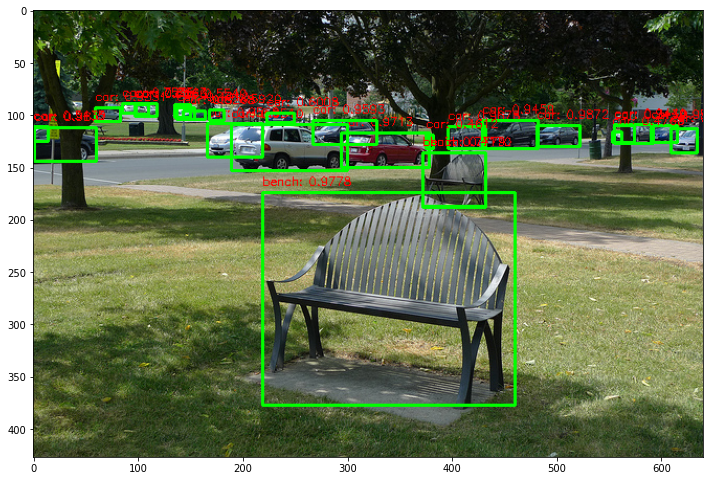

In [ ]:
import matplotlib.pyplot as plt

img_arr = cv2.imread('/content/mmdetection/demo/demo.jpg')
# 이미지 읽어오기
detected_img = get_detected_img(model, img_arr,  score_threshold=0.3, is_print=True)
# 위에서 정의해준, 함수에 입력
detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)
# 시각화를 위해서는 다시 RGB로 변경

#시각화
plt.figure(figsize=(12, 12))
plt.imshow(detected_img)

* Threshold = 0.9

car: 0.9888
car: 0.9872
car: 0.9832
car: 0.9713
car: 0.9678
car: 0.9594
car: 0.9593
car: 0.9568
car: 0.9510
car: 0.9459
car: 0.9440
car: 0.9331
bench: 0.9778


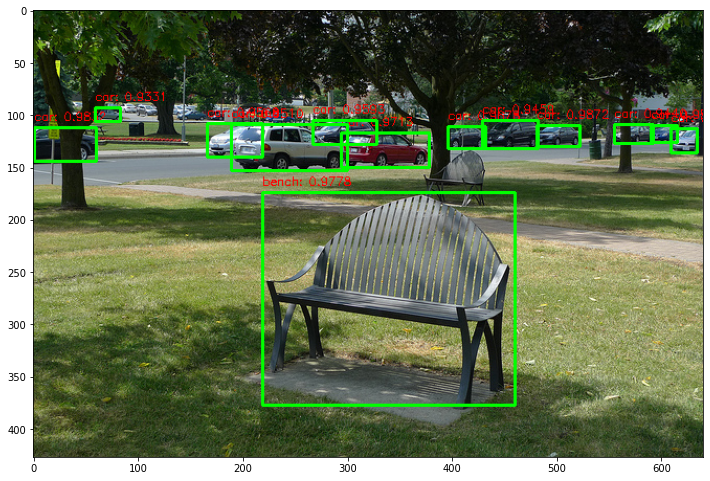

In [ ]:
import matplotlib.pyplot as plt

img_arr = cv2.imread('/content/mmdetection/demo/demo.jpg')
# 이미지 읽어오기
detected_img = get_detected_img(model, img_arr,  score_threshold=0.9, is_print=True)
# 위에서 정의해준, 함수에 입력
detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)
# 시각화를 위해서는 다시 RGB로 변경

#시각화
plt.figure(figsize=(12, 12))
plt.imshow(detected_img)

* 다른 데이터로 적용

In [ ]:
img_arr = cv2.imread('/content/drive/MyDrive/CDS2(2022-2)/img/test/car.png')

In [ ]:
img = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)

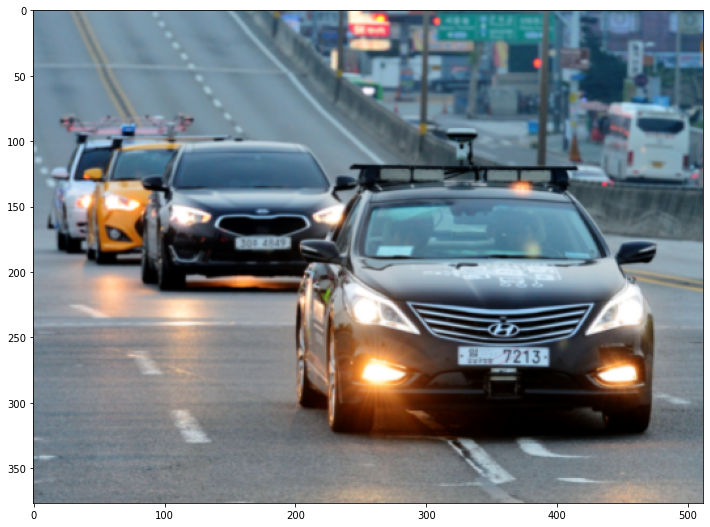

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(img)

car: 0.9735
car: 0.9565
car: 0.9452
car: 0.8904
car: 0.8900
car: 0.7917
truck: 0.6690


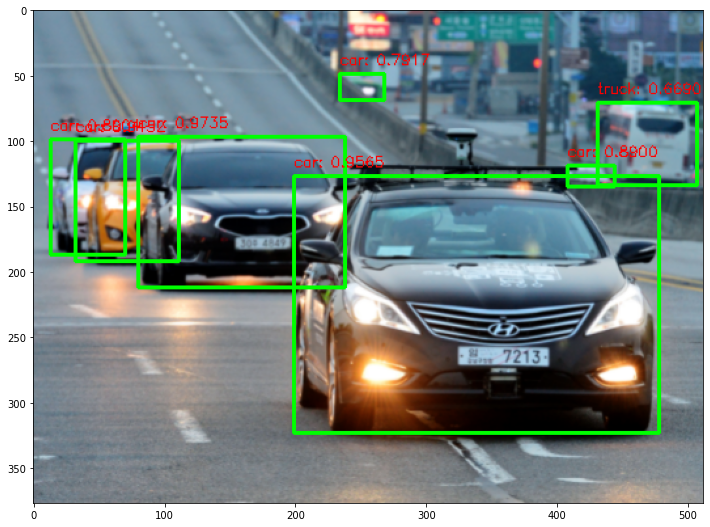

In [ ]:
img_arr = cv2.imread('/content/drive/MyDrive/CDS2(2022-2)/img/test/car.png')
detected_img = get_detected_img(model, img_arr,  score_threshold=0.5, is_print=True)
# detect 입력된 이미지는 bgr임. 이를 최종 출력시 rgb로 변환 
detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(detected_img)

person: 0.9992
person: 0.9991
person: 0.9987
person: 0.9986
person: 0.9984
person: 0.9984
person: 0.9960
tie: 0.9943
sports ball: 0.6789


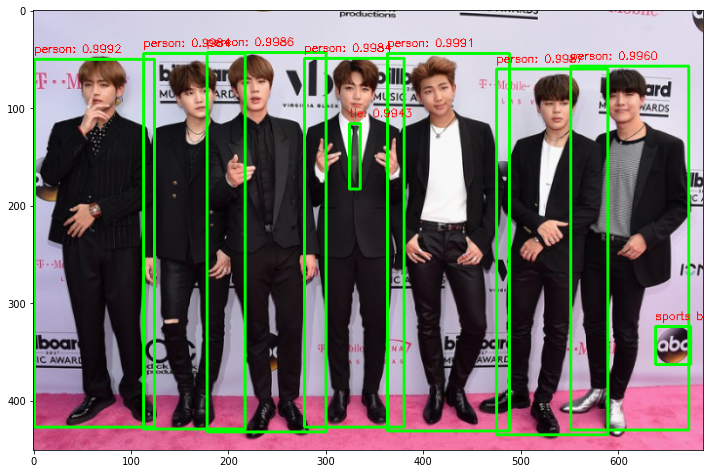

In [ ]:
img_arr = cv2.imread('/content/drive/MyDrive/CDS2(2022-2)/img/test/bts.png')
detected_img = get_detected_img(model, img_arr,  score_threshold=0.5, is_print=True)
# detect 입력된 이미지는 bgr임. 이를 최종 출력시 rgb로 변환 
detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(detected_img)

* 반도체 이미지에 적용이 가능할까?

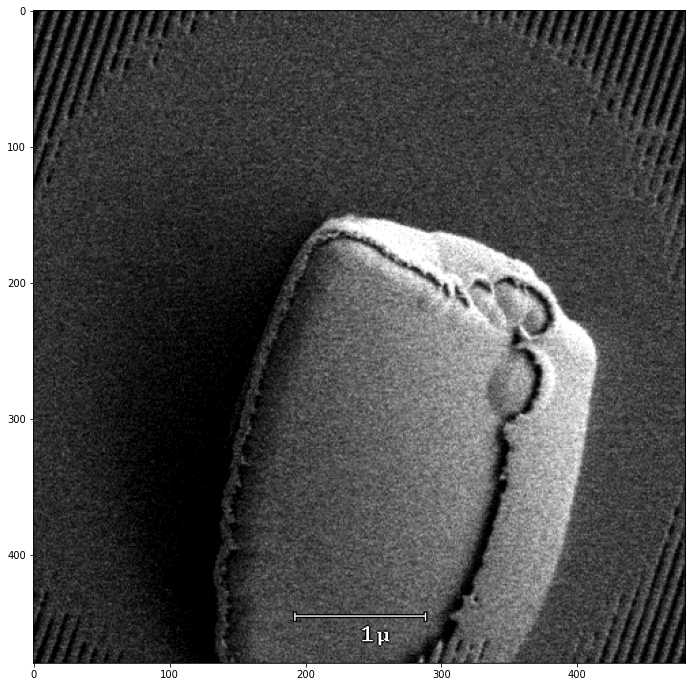

In [ ]:
img_arr = cv2.imread('/content/drive/MyDrive/CDS2(2022-2)/SEM_Dataset/IPTCL_CELL_TEST/20_LSAC/11.jpg')
detected_img = get_detected_img(model, img_arr,  score_threshold=0.5, is_print=True)
# detect 입력된 이미지는 bgr임. 이를 최종 출력시 rgb로 변환 
detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(detected_img)

→ CoCo Dataset으로 학습된 모델이기에 당연히 다른 class의 객체를 인식하지는 못한다. 